# Problem 1

First I will define some notation before I write the transition matrix in matrix/vector form.

Let $u_i = 
\begin{cases}
    \frac{1}{r_i},& \text{if } r_i \neq 0\\
    0,              & \text{otherwise}
\end{cases}
$

Let $v_i = 
\begin{cases}
    1,& \text{if } r_i \neq 0\\
    0,              & \text{otherwise}
\end{cases}
$

Let $w_i = 
\begin{cases}
    0,& \text{if } r_i \neq 0\\
    1,              & \text{otherwise}
\end{cases}
$

In scalar notation, 
$$
\begin{align}
p_{ij} &= p * A_{ij} * u_i + \frac{1 - p}{n} * v_i + \frac{1}{n} * w_i\\
& = p * A_{ij} * u_i + \frac{1}{n} - \frac{p}{n}*v_i\\
& = p * A_{ij} * u_i + n^{-1}(1 - p)v_i
\end{align}
$$

Let $\mathbf{u}, \mathbf{v}, \mathbf{w}$ be the corresponding column vectors. Let $1_n$ denote a $n\times 1$ column vector. Let $I_n$ be the $n\times n$ identity matrix.

$$P = p\cdot Diagonal(\mathbf{u}) \cdot A  + n^{-1}[I_n - Diagonal(\mathbf{v})\cdot p]\cdot 1_n 1_n'$$

# Problem 2

If $\mathbf{P}^{T}\mathbf{x} = \mathbf{x}$, then $(\mathbf{P}^{T} - \mathbf{I})\mathbf{x} = \mathbf{0}$

If we want to constrain $\mathbf{x}$ to have $\sum_{i=1}^{n}x_i = 1$, we can solve the augmented equation $\begin{pmatrix}1_n'\\\mathbf{P}^{T}-\mathbf{I}\end{pmatrix}\mathbf{x} = \begin{pmatrix}1\\0\\\vdots\\0\end{pmatrix}$

Number of pages is 500
Number of edges is 11158
Number of dangling pages is 96
The page with the max in-degree is page 1
The page with the max out-degree is page 36

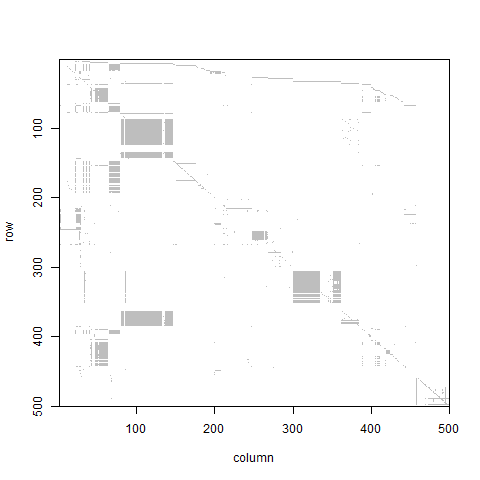


Attaching package: 'SparseM'

The following object is masked from 'package:base':

    backsolve



RCall.RObject{RCall.NilSxp}
NULL


In [40]:
# Problem 3

using RCall

# Number of pages
print("Number of pages is ", size(A)[1])

# Number of edges
print("\nNumber of edges is ", Int64(sum(A)))

# Number of dangling pages
print("\nNumber of dangling pages is ", size(A)[1] - countnz(sum(A, 2)))

# Page with max in-degree
print("\nThe page with the max in-degree is page ", indmax(sum(A, 1)))

# Page with max out-degree
print("\nThe page with the max out-degree is page ", indmax(sum(A, 2)))

# Visualize the sparsity pattern of A. I decided to use R because other Julia packages did not work
# well on my computer. 
@rput A

R"""
library(SparseM)
image(as.matrix.csr(A))
"""

In [157]:
# Problem 4

function transition(A, p)
    n, m = size(A)
    u, v = Array(Float64, 500), Array(Float64, 500)

    for i = 1:500
        if sum(A, 2)[i] == 0.0
            u[i] = 0.0
            v[i] = 0.0
        else
            u[i] = 1.0 / sum(A, 2)[i]
            v[i] = 1.0
        end
    end
    return p * Diagonal(u) * A + 1 / n * (I - Diagonal(v) * p) * ones(n) * ones(n)'
end

# Read in nxn connectivity matrix
A = readcsv("E:/Classes/BiostatisticsM280/Submissions/biostat-m280-JohnShamshoian/HW3/A.txt");
p = .85

# Create transition matrix
P = transition(A, p);

# Augment the transition matrix to have the top left eigenvector sum to one
augP = vcat(ones(size(A)[1])', P' - I)

In [158]:
# Augment the transition matrix to have the top left eigenvector sum to one
augP = vcat(ones(size(A)[1])', P' - I)

# Dense linear solver
qrfact(augP, Val{true}) \ vcat(1, zeros(500))

# Dense eigensolver
v = Float64.(eigvecs(P')[:, 1])
v/sum(v)

# Power method
for i = 1:100
    x = (P' * x) / norm(P' * x)
end
x/sum(x);

In [69]:
function transition(A, p)
    n, m = size(A)
    u, v = Array(Float64, 500), Array(Float64, 500)

    for i = 1:500
        if sum(A, 2)[i] == 0.0
            u[i] = 0.0
            v[i] = 0.0
        else
            u[i] = 1.0 / sum(A, 2)[i]
            v[i] = 1.0
        end
    end
    return p * Diagonal(u) * A + 1 / n * (I - Diagonal(v) * p) * ones(n) * ones(n)'
end

transition (generic function with 1 method)

 overwritten at In[69]:2.
